# Tutorial

In [1]:
from mol_inspector import Inspector, Plots, MolInspector
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import pandas as pd

## Create Random Forest Model
This example will first create a simple Random Forest model using the SARSCoV2_Vitro_Touret from the [Therapeutics Data Commons](https://tdcommons.ai). The [dataset](data/SARSCoV2_Vitro_Touret.csv) has been saved in the data folder for this tutorial.

In [2]:
data = pd.read_csv("data/SARSCoV2_Vitro_Touret.csv")
data.head(5)

,Drug_ID,Drug,Y
0,0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,1
1,1,C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...,1
2,2,Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl,1
3,3,CC(=O)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C...,1
4,4,C=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3C...,1


### Generate Molecular Fingerprints
For each molecule smiles string, a Morgan fingerprint will be generated. This will then be appended to the data table.

In [3]:
# fingerprint
fp_list = []
for x in data['Drug']:
    mol = Chem.MolFromSmiles(x)
    mfp = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
    fp = mfp.GetFingerprint(mol)
    fp = [int(b) for b in fp]
    fp_list.append(fp)
# fp dataframe
fp_df = pd.DataFrame(fp_list, columns=[f'fp{i}' for i in range(1024)])

# combine the original dataframe with fp dataframe
data = pd.concat([data, fp_df], axis=1)
data.head()

,Drug_ID,Drug,Y,fp0,fp1,fp2,fp3,fp4,fp5,fp6,...,fp1014,fp1015,fp1016,fp1017,fp1018,fp1019,fp1020,fp1021,fp1022,fp1023
0,0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2,Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,3,CC(=O)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C...,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,4,C=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3C...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Split Dataset
The dataframe information containing the labels and fingerprints will be split into training and test datasets. The training data will be used to fit to teh RandomForestClassifier().

In [4]:
# extract features and labels
features = data.filter(regex=r'^fp')
labels = data.filter(regex=r'^Y')
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train.values.ravel())

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Initialize mol-inspector classes

### Initialize Inspector
Calling the Inspector() class will generate the SHAP values. By default, it will use the SHAP auto to determine the model type, however, users can also specify which SHAP explainer to use. Calling the Inspector() class will generate a print statement to ensure the correct SHAP explainer is called.

In [5]:
inspector = Inspector(model=rf, train_feats=X_train)

Inspector Initialized Tree Explainer


### Generate SHAP Values
The SHAP values are generated using the values() method. This requires a set used for testing the model or the set used for model prediction.

In [6]:
# test_feats = test_feats.head(20)
values = inspector.values(X_test)
type(values)

shap._explanation.Explanation

The values can be converted into a pd.DataFrame. This is handy if users would prefer to make additional plots from the SHAP value data.

In [7]:
inspector.to_df(values, shap_type="values")

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,...,fp1014,fp1015,fp1016,fp1017,fp1018,fp1019,fp1020,fp1021,fp1022,fp1023
0,-0.000008,-0.000140,-0.000733,0.000017,-0.000911,-0.000022,-0.001197,0.000010,2.451667e-03,0.0,...,-0.000033,-0.000092,0.0,-0.000281,0.000000e+00,0.000105,-0.000386,5.000000e-06,0.0,0.0
1,-0.000003,-0.000016,-0.000332,0.000000,-0.000503,0.000010,-0.001425,0.000042,-4.833333e-05,0.0,...,-0.000117,-0.000050,0.0,-0.000283,0.000000e+00,-0.000201,-0.000408,1.333333e-05,0.0,0.0
2,-0.000008,-0.000036,-0.000243,0.000000,-0.000412,-0.000042,-0.001170,-0.000017,8.333332e-06,0.0,...,-0.000050,-0.000150,0.0,-0.000233,0.000000e+00,0.000059,-0.000447,3.571429e-07,0.0,0.0
3,-0.000008,-0.000088,-0.000356,0.000000,0.001762,-0.000025,-0.001400,0.000062,-5.813492e-05,0.0,...,-0.000013,-0.000062,0.0,0.002118,7.936508e-07,-0.000538,0.002371,1.000000e-05,0.0,0.0
4,-0.000008,-0.000063,-0.000640,-0.000148,0.000651,-0.000188,-0.001271,0.001682,1.116667e-04,0.0,...,-0.000017,-0.000033,0.0,-0.000187,0.000000e+00,-0.000147,-0.000464,-1.176190e-04,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,-0.000003,-0.000980,-0.000271,0.000000,-0.000367,-0.000042,-0.001117,0.000076,9.523798e-07,0.0,...,-0.000017,-0.000150,0.0,-0.000236,0.000000e+00,0.000095,-0.000428,-3.761905e-05,0.0,0.0
293,-0.000008,-0.000053,-0.000365,0.000000,0.001492,-0.000042,-0.001513,0.000042,9.523798e-07,0.0,...,-0.000033,-0.000067,0.0,-0.000291,0.000000e+00,0.000593,-0.000297,0.000000e+00,0.0,0.0
294,-0.000058,-0.000109,-0.000466,-0.000025,-0.001386,0.000312,-0.001313,0.000080,1.666667e-05,0.0,...,-0.000017,-0.000045,0.0,-0.000417,0.000000e+00,-0.000350,-0.000295,7.142857e-07,0.0,0.0
295,-0.000008,-0.000753,-0.000269,0.000000,-0.001042,-0.000042,-0.001227,0.000006,9.285714e-06,0.0,...,-0.000033,-0.000050,0.0,-0.000263,-3.559524e-05,-0.000251,0.000875,5.000000e-06,0.0,0.0


### Plotting
The mol-inspector converted 3 types of plots - the summary plot, bar plot, and scatter plot. Each gives a different explination of the machine learning model.
- summary_plot() will give a summary of the top influential features.
- bar() will plot the average SHAP values for top features as well as top features for a given query
- scatter() will show display how a specific feature can increase the SHAP values for a given dataset.

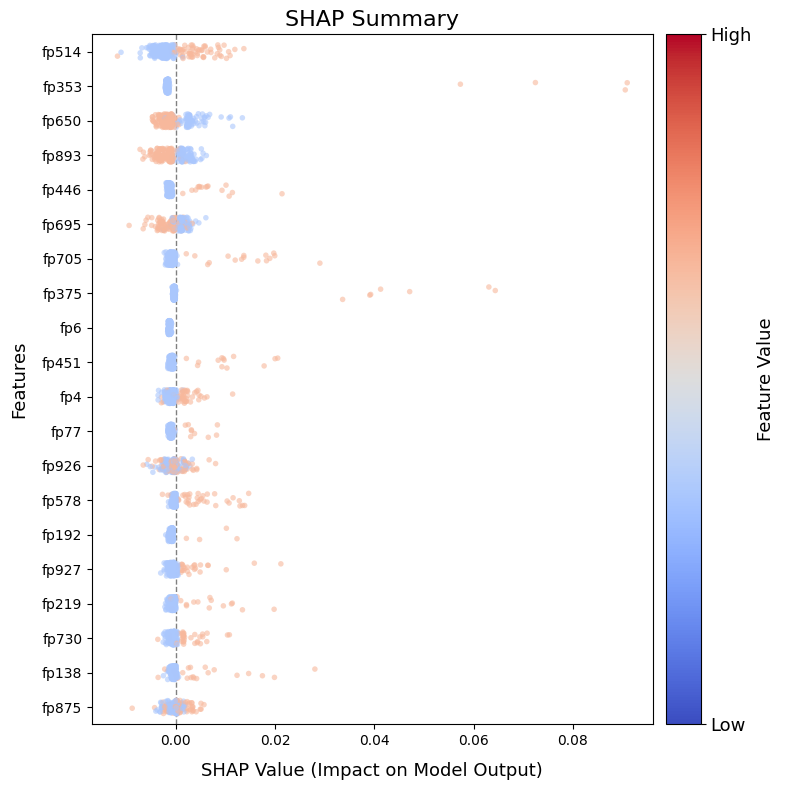

In [8]:
plot = Plots(values, X_train, X_test)
"""Give a summary of the top influential features"""
plot.summary_plot()

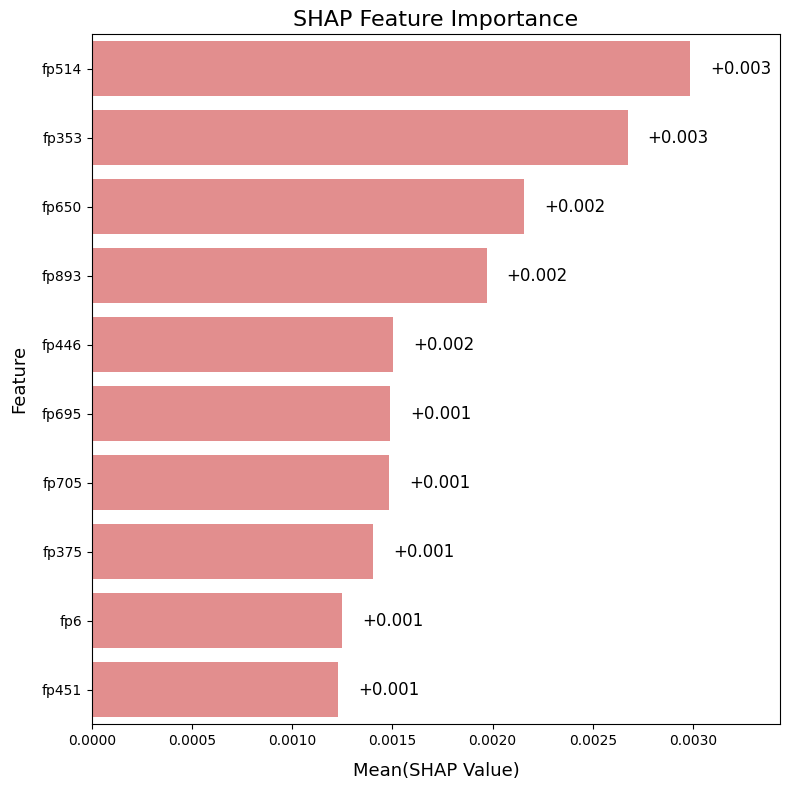

In [9]:
"""Shows the average SHAP value for given features"""
plot.bar()

### Plotting - Specific Dataset
The Feature Importance can also be generated for specific dataset query. In this case, the first item from the test set will be used.

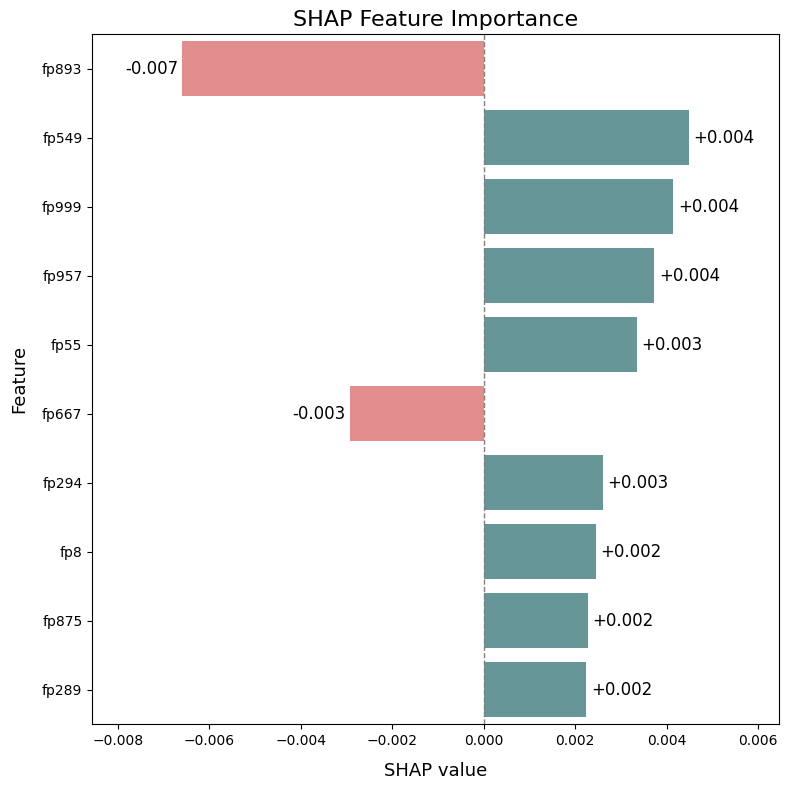

In [10]:
"""Shows SHAP value for individual query"""
plot.bar(test_idx=0)

A scatterplot showing the SHAP values for a specific input value can also be given. In this case, the fingerprint bit 893 was selected.

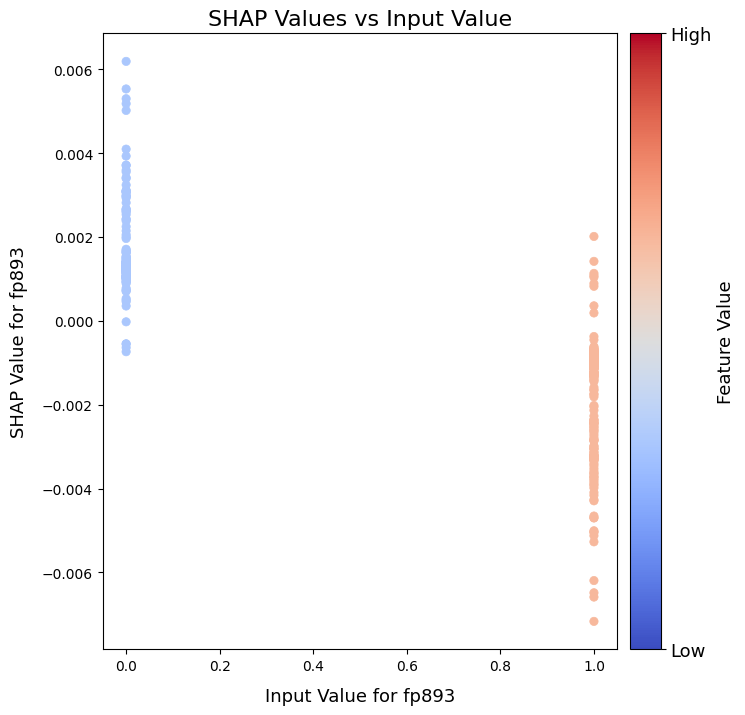

In [11]:
plot.scatterplot(feature="fp893")

### Visualizing Fingerprint Bit
RDKit includes methods to draw the fingerprint bit. This is a handy method to visualize and analyze the molecules. The example molecule was the first item in the X_test dataset.

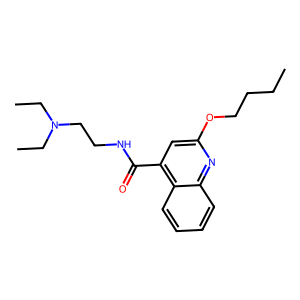

In [12]:
# First molecule from X_test, Drug_ID 123
smi = 'CCCCOc1cc(C(=O)NCCN(CC)CC)c2ccccc2n1'

from rdkit import Chem
from rdkit.Chem import Draw
# Convert SMILES to a molecule
mol = Chem.MolFromSmiles(smi)

# Draw the molecule
Draw.MolToImage(mol)

### Rendering Fingerprint Bits
If users are using molecular fingerprints in their models, this can be drawn using functions in mol-inspector. Currently only Morgan and RDKit fingerprints are supported. When the MolInspector() is called, it will generate a dictioanry of fingerprint bits and its associated data. This will then be rendered using the render_bit() method. Finally, an interactive widget is available to render the fingerprint bits. However, this is only available for use in Jupyter notebooks.

In [13]:
info = MolInspector(smi=smi, fp_type='morgan', n_bits=1024)

In [14]:
info.bit_info

{8: ((10, 2),),
 13: ((3, 1),),
 33: ((0, 0), (15, 0), (17, 0)),
 55: ((18, 2),),
 64: ((20, 1), (21, 1)),
 73: ((23, 1),),
 80: ((1, 0), (2, 0), (3, 0), (11, 0), (12, 0), (14, 0), (16, 0)),
 105: ((6, 2),),
 128: ((10, 0),),
 175: ((20, 2), (21, 2)),
 197: ((10, 1),),
 249: ((5, 2),),
 251: ((13, 1),),
 253: ((11, 2),),
 289: ((22, 2),),
 293: ((8, 2),),
 294: ((0, 1), (15, 1), (17, 1)),
 333: ((18, 1),),
 356: ((5, 0), (7, 0), (18, 0), (23, 0)),
 378: ((24, 0),),
 379: ((7, 2),),
 389: ((23, 2),),
 428: ((4, 1),),
 486: ((8, 1),),
 546: ((5, 1),),
 549: ((19, 2),),
 586: ((12, 2),),
 591: ((1, 2),),
 620: ((13, 2),),
 650: ((9, 0),),
 667: ((11, 1),),
 695: ((4, 0),),
 706: ((4, 2),),
 718: ((2, 2),),
 726: ((19, 1), (22, 1)),
 794: ((1, 1),),
 807: ((8, 0),),
 831: ((24, 1),),
 849: ((6, 0), (19, 0), (20, 0), (21, 0), (22, 0), (3, 2)),
 875: ((6, 1),),
 881: ((13, 0),),
 887: ((2, 1),),
 893: ((9, 1),),
 927: ((12, 1),),
 932: ((14, 1), (16, 1)),
 957: ((14, 2), (16, 2)),
 967: ((7,

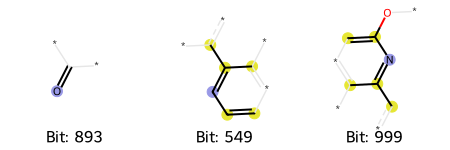

In [15]:
test = info.visualize_fp(bit_query=[893, 549, 999], n_mols=3) # morgan
test

### Interactive Widget
The interactive widget is only available for use in Juypter Notebooks. It is a handy way for users to cycle through the fingerprint bits for their query molecules.

In [16]:
info.render_bit()

interactive(children=(Dropdown(description='Select Bit:', options=(8, 13, 33, 55, 64, 73, 80, 105, 128, 175, 1…